# North Simba quicklook

channel 1, Piggy, LOVE_Simba_north_artifacts_190730

Looking at the mapping and properties of the North Simba in general, not quality checking for a specific run.

In [1]:
from IPython.display import HTML

hide_me = ''
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import yaml

# OS interaction
import os


# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import pandas as pd
import copy
import btmm_process
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import warnings
warnings.filterwarnings("ignore")

## Format plots

In [3]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']
ms_list = ['v', '*', 's', 'o']

alphabet = list(string.ascii_lowercase)

### Directories

In [4]:
# Name of the DTS configuration.
exp_name = 'LOVE_Simba_north_artifacts_190730'

# Determine which computer I am on
computer = os.environ.get('LOCALNAME')
if computer == 'btgmm8.geo.uni-bayreuth.de':
    dir_pre = os.path.join('/Users/karllapo/Desktop/proj/DarkMix_Voitsumra')
elif computer == 'MARVIN':
    dir_pre = os.path.join('/Users/karllapo/gdrive/proj/DarkMix_Voitsumra')

# DTS data
dir_dts_data = os.path.join(dir_pre, 'love_dts', exp_name)
dir_data_cal = os.path.join(dir_dts_data, 'calibrated')
dir_data_proc = os.path.join(dir_dts_data,  'processed')
dir_data_raw = os.path.join(dir_dts_data,  'raw_netcdf')

# Met data
dir_logger_data = os.path.join(dir_pre, 'logger_data')
dir_rbr_data = os.path.join(dir_logger_data, 'RBR_Data')

# Figures
dir_print = os.path.join(dir_pre, 'figures')

## Raw data

- Examine the time-averaged instrument reported temperatures.
- Explore for power step-losses and necessary correction.
- Examine the bath temperature time series.
- Make sure the mapping is reasonable.

To do this I am loading 4 hours of data spanning between night and day. Later in the document I examine a day time and night time period separately (tower mapping verification).

In [5]:
os.chdir(dir_data_raw)
dsraw = xr.open_mfdataset('raw_channel 1_20190731-0[5-9]*.nc')

dsraw_mean = dsraw.temp.mean(dim='time')
dsraw_std = dsraw.temp.std(dim='time')

# Data Overview

## Instrument Reported Temperature

Text(0.5, 0, 'LAF (m)')

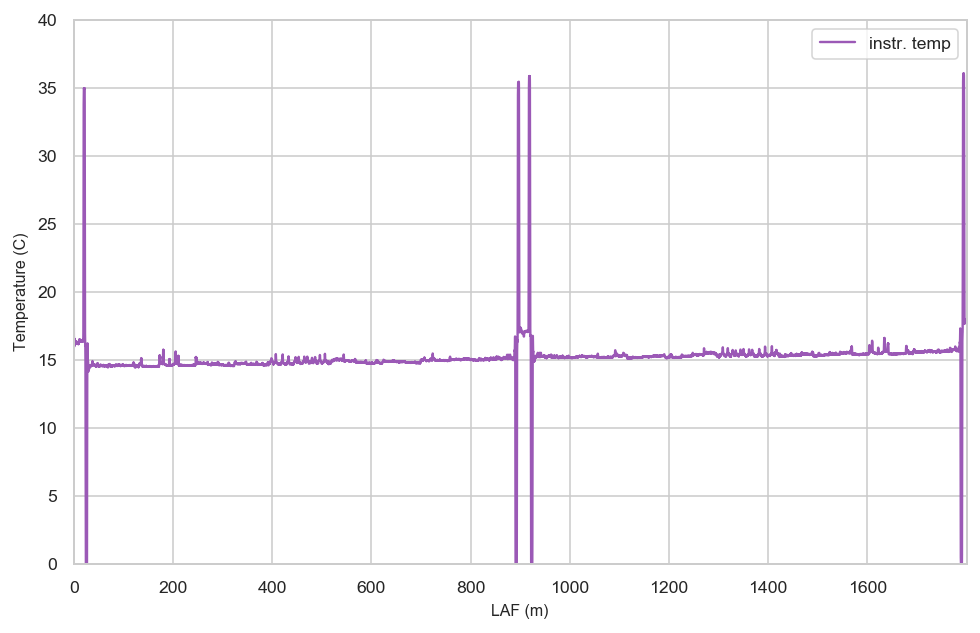

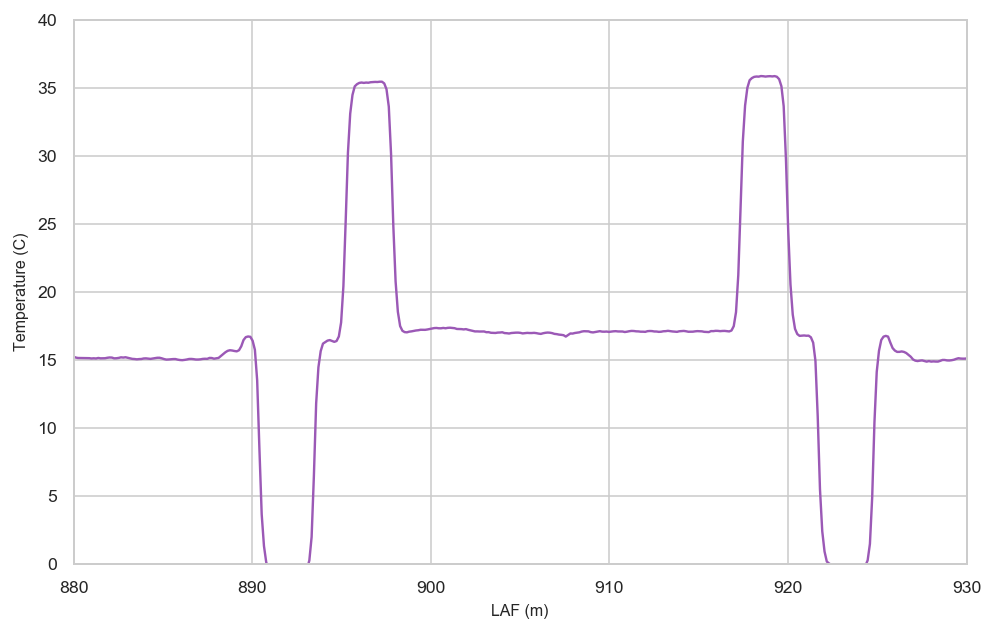

In [6]:
# Let's look at the entire fiber
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dsraw.LAF, dsraw.temp.mean(dim='time').values, label='instr. temp')

ymin = 0
ymax = 40
ax.set_ylim(ymin, ymax)
ax.set_xlim(0, dsraw.LAF.max())

ax.legend(loc='best')
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('LAF (m)')

os.chdir(dir_print)
# fig.savefig(exp_name + '.raw.ql.pdf')

# Splice between cores
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dsraw.LAF, dsraw.temp.mean(dim='time').values, label='instr. temp')

ymin = 0
ymax = 40
ax.set_ylim(ymin, ymax)
ax.set_xlim(880, 930)
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('LAF (m)')

Create two cores with the split around 900m (exact location is not important).

## $log(\frac{P_s}{P_{as}})$

In [7]:
power = np.log(dsraw.Ps / dsraw.Pas)
power_timeavg = power.mean(dim='time')
power_timestd = power.std(dim='time')

In [ ]:
# Let's look at the entire fiber
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dsraw.LAF, power_timeavg.values)
ax.fill_between(power.LAF, power_timeavg.values - power_timestd.values, power_timeavg.values + power_timestd, color=flatui[0], alpha=0.5)
# ymin = 0
# ymax = 40
ax.set_ylim(0.1, 0.4)
ax.set_xlim(0, dsraw.LAF.max())

ax.legend(loc='best')
ax.set_ylabel('Power')
ax.set_xlabel('LAF (m)')

# LAF of std
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(power.LAF, power_timestd.values)

ax.set_ylim(0.005, 0.015)
ax.set_xlim(0, dsraw.LAF.max())

No handles with labels found to put in legend.


# Baths

### Old bath locations

Keep these values for future reference. These are the values that were found when using an ice pack. They were found by eye and should not be the final values used.

In [ ]:
# Read location library
phys_locs_file = '/Users/karllapo/Desktop/proj/DarkMix_Voitsumra/love_dts/NorthSimba_towermane_physloc.v4_082819.yml'
phys_locs = yaml.load(phys_locs_file)
with open(phys_locs_file, 'r') as stream:
    phys_locs = yaml.load(stream)
phys_locs = phys_locs['location_library']

# For reference, here are the old (and incorrect) bath locations
bath_locs_old = {'warmnear': {'LAF': {'core A': [20.2, 22.2], 'core B': [917.75, 919.5]}},
                 'warmfar': {'LAF': {'core A': [895.6, 897.4], 'core B': [1793.0, 1795.0]}},
                 'coldnear': {'LAF': {'core A': [24.25, 26.5], 'core B': [922.25, 924.25]}},
                 'coldfar': {'LAF': {'core A': [891.0, 893.0], 'core B': [1788.5, 1790.5]}}
                }

In [ ]:
bathnames = ['warmnear', 'warmfar', 'coldnear', 'coldfar']
cores = ['core A', 'core B']

# ------------------------
# OLD BATH LOCATIONS
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.set_title(c + ': ' + bn)
        bath_start = bath_locs_old[bn]['LAF'][c][0]
        bath_end = bath_locs_old[bn]['LAF'][c][1]
        ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8)
        ax.plot(dsraw.LAF, dsraw_mean.values)
        ax.set_xlim(bath_start - 2.5, bath_end + 2.5)
        if 'warm' in bn:
            ax.set_ylim(20, 38)
        elif 'cold' in bn:
            ax.set_ylim(-5, 20)
        ax.set_ylabel('Temperature (C)')
        ax.set_xlabel('LAF (m)')
fig.tight_layout()


## Refining the bath location

This is an iterative process and I've revisited these limits several times.

### Instrument Reported Temperature

In [ ]:
# Store the old (and incorrect) bath locations - v1
bath_locs_prev = {'warmnear': {'LAF': {'core A': [20.4, 22.0], 'core B': [917.9, 919.3]}},
                 'warmfar': {'LAF': {'core A': [895.8, 897.2], 'core B': [1793.0, 1794.5]}},
                 'coldnear': {'LAF': {'core A': [24.5, 26.5], 'core B': [922.25, 924.25]}},
                 'coldfar': {'LAF': {'core A': [891.0, 893.0], 'core B': [1788.5, 1790.2]}}
                }

# Store the old (and incorrect) bath locations - v2
# bath_locs_new = {'warmnear': {'LAF': {'core A': [20.6, 21.8], 'core B': [918.2, 919.4]}},
#                  'warmfar': {'LAF': {'core A': [896.1, 897.2], 'core B': [1793.3, 1794.5]}},
#                  'coldnear': {'LAF': {'core A': [24.7, 26.3], 'core B': [922.6, 924.1]}},
#                  'coldfar': {'LAF': {'core A': [891.2, 892.9], 'core B': [1788.9, 1790.1]}}
#                 }

# Store the old (and incorrect) bath locations - v3
bath_locs_new = {'warmnear': {'LAF': {'core A': [20.7, 21.7], 'core B': [918.2, 919.3]}},
                 'warmfar': {'LAF': {'core A': [896.1, 897.1], 'core B': [1793.3, 1794.4]}},
                 'coldnear': {'LAF': {'core A': [24.7, 26.2], 'core B': [922.6, 924.1]}},
                 'coldfar': {'LAF': {'core A': [891.2, 892.6], 'core B': [1788.9, 1790.1]}}
                }

# ------------------------
# NEW BATH LOCATIONS
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.set_title(c + ': ' + bn)
        
        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]
        
        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8)
        
        # The instrument reported temperature data
        ax.plot(dsraw.LAF, dsraw_mean.values)

        # The previous iteration of bath locations for comparison
        ax.plot([bath_locs_prev[bn]['LAF'][c][0], bath_locs_prev[bn]['LAF'][c][0]], [-20, 60], 'k--')
        ax.plot([bath_locs_prev[bn]['LAF'][c][1], bath_locs_prev[bn]['LAF'][c][1]], [-20, 60], 'k--')
        
        ax.set_xlim(bath_start - .5, bath_end + .5)
        
        if 'warm' in bn:
            ax.set_ylim(32, 38)
        elif 'cold' in bn:
            ax.set_ylim(-5, 5)
        ax.set_ylabel('Temperature (C)')
        ax.set_xlabel('LAF (m)')
fig.tight_layout()


### $log(\frac{P_s}{P_as})$

Repeat the process with the power ratio

In [ ]:
# Store the old (and incorrect) bath locations - v1

# ------------------------
# Mean of power
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]
        mean_power = power.sel(LAF=slice(bath_start, bath_end)).mean(dim='LAF').mean(dim='time').values
        
        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # Power perturbation
        ax.plot(dsraw.LAF, power_timeavg.values - mean_power)

        # The previous iteration of bath locations for comparison
        ax.plot([bath_locs_prev[bn]['LAF'][c][0], bath_locs_prev[bn]['LAF'][c][0]], [-20, 60], 'k--', label='Old Baths')
        ax.plot([bath_locs_prev[bn]['LAF'][c][1], bath_locs_prev[bn]['LAF'][c][1]], [-20, 60], 'k--')
        
        ax.set_xlim(bath_start - .5, bath_end + .5)
        ax.set_ylim(-0.005, 0.005)

        ax.set_ylabel(r'$log(\frac{Ps}{Pas}) - \overline{log(\frac{Ps}{Pas})}$')
        ax.set_xlabel('LAF (m)')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()


In [ ]:
# ------------------------
# Mean of power
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]
        bath_ps = dsraw['Ps'].sel(LAF=slice(bath_start, bath_end)).mean(dim='LAF').mean(dim='time').values
        
        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], 0, 6000, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # Power perturbation
        ax.plot(dsraw.LAF, dsraw.Ps.mean(dim='time'), label='Ps')
        ax.plot(dsraw.LAF, dsraw.Pas.mean(dim='time'), label='Pas')
        
        ax.set_xlim(bath_start - .5, bath_end + .5)
        ax.set_ylim(bath_ps - 10, bath_ps + 10)

        ax.set_ylabel('Power intensity')
        ax.set_xlabel('LAF (m)')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()


# ------------------------
# Mean of power
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]
        bath_ps = dsraw['Ps'].sel(LAF=slice(bath_start, bath_end)).mean(dim='LAF').mean(dim='time').values
        bath_pas = dsraw['Pas'].sel(LAF=slice(bath_start, bath_end)).mean(dim='LAF').mean(dim='time').values
        
        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], 0, 6000, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # Power perturbation
        ax.plot(dsraw.LAF, dsraw.Pas.mean(dim='time'), label='Pas')
        
        ax.set_xlim(bath_start - .5, bath_end + .5)
        ax.set_ylim(bath_pas - 10, bath_pas + 10)

        ax.set_ylabel('Power intensity')
        ax.set_xlabel('LAF (m)')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()


In [ ]:

# ------------------------
# Mean of power
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]
        bath_ps = dsraw['Ps'].sel(LAF=slice(bath_start, bath_end)).mean(dim='LAF').mean(dim='time').values
        bath_pas = dsraw['Pas'].sel(LAF=slice(bath_start, bath_end)).mean(dim='LAF').mean(dim='time').values
        delta_stokes = bath_ps - bath_pas
        
        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], 0, 6000, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # Power perturbation
        ax.plot(dsraw.LAF, dsraw.Pas.mean(dim='time') + delta_stokes, label='Pas')
        ax.plot(dsraw.LAF, dsraw.Ps.mean(dim='time'), label='Ps')
        
        ax.set_xlim(bath_start - .5, bath_end + .5)
        ax.set_ylim(bath_ps - 10, bath_ps + 10)

        ax.set_ylabel('Power intensity')
        ax.set_xlabel('LAF (m)')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()

In [ ]:
# ------------------------
# Standarad deviation of power
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]
        
        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # The instrument reported temperature data
        ax.plot(dsraw.LAF, power_timestd.values)

        # The previous iteration of bath locations for comparison
        ax.plot([bath_locs_prev[bn]['LAF'][c][0], bath_locs_prev[bn]['LAF'][c][0]], [-20, 60], 'k--', label='Old Baths')
        ax.plot([bath_locs_prev[bn]['LAF'][c][1], bath_locs_prev[bn]['LAF'][c][1]], [-20, 60], 'k--')
        
        ax.set_xlim(bath_start - 2, bath_end + 2)
        ax.set_ylim(0, 0.015)

        ax.set_ylabel(r'$\sigma(log(\frac{Ps}{Pas}))$')
        ax.set_xlabel('LAF (m)')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()

### Spatial derivative of power

In [ ]:
# ------------------------
# Standarad deviation of power
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Derivative
dP_dLAF = power.diff(dim='LAF').mean(dim='time')
dP_dLAF_sigma = power.diff(dim='LAF').std(dim='time')

for nc, c in enumerate(cores):
    for bn_num, bn in enumerate(bathnames):
        ax = axes[nc, bn_num]
        ax.xaxis.grid(True, which='minor')
        ax.set_title(c + ': ' + bn)

        bath_start = bath_locs_new[bn]['LAF'][c][0]
        bath_end = bath_locs_new[bn]['LAF'][c][1]

        # Fill in the "current" bath locations
        ax.fill_between([bath_start, bath_end], -20, 60, edgecolor='k', facecolor='0.9', alpha=0.8, label='New Baths')

        # The instrument reported temperature data
        ax.plot(dsraw.LAF[0:-1], dP_dLAF.values)
        ax.fill_between(dsraw.LAF[0:-1].values, dP_dLAF - dP_dLAF_sigma, dP_dLAF + dP_dLAF_sigma, color=flatui[0], alpha=0.5)

        # The previous iteration of bath locations for comparison
        ax.plot([bath_locs_prev[bn]['LAF'][c][0], bath_locs_prev[bn]['LAF'][c][0]], [-20, 60], 'k--', label='Old Baths')
        ax.plot([bath_locs_prev[bn]['LAF'][c][1], bath_locs_prev[bn]['LAF'][c][1]], [-20, 60], 'k--')
        
        ax.set_xlim(bath_start - 2, bath_end + 2)
        ax.set_ylim(-0.05, 0.05)

        ax.set_ylabel(r'$\frac{d(log(\frac{Ps}{Pas}))}{LAF} (dB/m)$')
        ax.set_xlabel('LAF (m)')
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.legend(loc='upper right', frameon=True)
fig.tight_layout()

These new bath locations seem to be far enough away from the edge effects. Let's assign these to the `phys_locs` variable and see how the power looks.

In [ ]:
for bn in bathnames:
    phys_locs[bn]['LAF'] = bath_locs_new[bn]['LAF']

## Reference Temperatures

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True)

ax = axes[0]
ax.plot(dsraw.time.values, dsraw.warmProbe.values)
ax.set_title('Warm Probe')

ax = axes[1]
ax.plot(dsraw.time.values, dsraw.coldProbe.values)
ax.set_title('Cold Probe')

fig.autofmt_xdate()
fig.tight_layout()

The baths look fantastic! No evidence of mechanical strain or power loss within the bath like in previous iterationsn.

# Splices/Offset Corrections

In [ ]:
splice_config = 'LOVE_Simba_north_190715'
os.chdir(os.path.join(dir_pre, 'love_dts', splice_config, 'raw_netcdf'))
splice_files = 'raw_channel 1_20190716-1[2-6]*.nc'
dsraw_splice = xr.open_mfdataset(splice_files)
print(dsraw_splice)

In [ ]:
splice_names = ['conedsplice1', 'conedsplice2']
steploss_corr = {'conedsplice1': {'core A': 0.0, 'core B': 0.0},
                 'conedsplice2': {'core A': -0.0003, 'core B': 0.0},
                }
splice_times = {'conedsplice1': ['2019-07-16 12:40:00', '2019-07-16 13:35:00'],
                'conedsplice2': ['2019-07-16 14:30:00', '2019-07-16 14:42:00'],
               }

for nc, c in enumerate(cores):
    for n_spl, spl in enumerate(splice_names):
        fig, axes = plt.subplots(4, 1, figsize=(6, 6), sharex=True)
        
        splice_corr = dsraw_splice.sel(time=slice(splice_times[spl][0], splice_times[spl][1])).mean(dim='time')
        splice_corr['power'] = np.log(splice_corr.Ps / splice_corr.Pas)
        
        splice_beg = phys_locs[spl]['LAF'][c][0]
        splice_end = phys_locs[spl]['LAF'][c][1]
        splice_LAF = np.mean([splice_beg, splice_end])
        mean_power = splice_corr['power'].sel(LAF=slice(splice_beg, splice_end)).mean(dim='LAF').values

        splice_corr['corr_power'] = splice_corr.power.where((splice_corr.LAF < splice_LAF), splice_corr.power + steploss_corr[spl][c])

        # Power plot
        ax = axes[0]
        ax.plot(splice_corr.LAF, splice_corr['power'].values - mean_power, label='Original')
        ax.plot(splice_corr.LAF, splice_corr['corr_power'].values - mean_power, label='Corrected')
        ax.fill_between([splice_beg, splice_end], -10, 50, edgecolor='0.8', facecolor='0.9', alpha=0.8)
        
        ax.legend()
        ax.set_ylim(-.002, 0.002)
        ax.set_ylabel('log(Ps/Pas)')
        ax.set_title(spl + ' ' + c)
        
        # Temperature plot
        ax = axes[1]
        ax.plot(splice_corr.LAF, splice_corr['temp'].values, label='Instr. Reported')
        ax.fill_between([splice_beg, splice_end], 0, 50, edgecolor='0.8', facecolor='0.9', alpha=0.8)

        ax.set_ylabel('Temperature (C)')
        ax.set_xlim(splice_beg - 0.5, splice_end + 0.5)
        ax.set_xlabel('LAF (m)')
        ax.set_ylim(15, 25)
        
        # Standard deviation of power ratios -- max in time
        ax = axes[2]
        rolling_Ps = dsraw_splice.sel(time=slice(splice_times[spl][0], splice_times[spl][1]))['Ps'].rolling(LAF=10, center=True).std().max(dim='time')
        rolling_Pas = dsraw_splice.sel(time=slice(splice_times[spl][0], splice_times[spl][1]))['Pas'].rolling(LAF=10, center=True).std().max(dim='time')
        ax.plot(rolling_Ps.LAF, rolling_Ps.values, label='Ps')
        ax.plot(rolling_Pas.LAF, rolling_Pas.values, label='Pas')
        ax.fill_between([splice_beg, splice_end], 0, 50, edgecolor='0.8', facecolor='0.9', alpha=0.8)

        ax.legend()
        ax.set_ylabel('$\sigma(LAF=10)$, max in time')
        ax.set_xlim(splice_beg - 0.5, splice_end + 0.5)
        ax.set_xlabel('LAF (m)')
        ax.set_ylim(0, 100)
        
        # Standard deviation of power ratios
        ax = axes[3]
        rolling_Ps = dsraw_splice.sel(time=slice(splice_times[spl][0], splice_times[spl][1]))['Ps'].rolling(LAF=10, center=True).std().mean(dim='time')
        rolling_Pas = dsraw_splice.sel(time=slice(splice_times[spl][0], splice_times[spl][1]))['Pas'].rolling(LAF=10, center=True).std().mean(dim='time')
        ax.plot(rolling_Ps.LAF, rolling_Ps.values - rolling_Pas.values)
        ax.fill_between([splice_beg, splice_end], 0, 50, edgecolor='0.8', facecolor='0.9', alpha=0.8)
        ax.plot([0, dsraw.LAF.max()], [0, 0], 'k--')
        ax.set_ylabel('$\overline{\sigma(P_s)} - \overline{\sigma{P_{as}}}$')
        ax.set_xlim(splice_beg - 0.5, splice_end + 0.5)
        ax.set_xlabel('LAF (m)')
        ax.set_ylim(-50, 10)


ZERO STEP LOSS! Anita did an amazing job on these splices. The grey region is the estimated length of fiber inside the ambient temperature bath, found using an ice pack on the fiber as it enters/leaves the bath. The time averaged over is the time that the fiber was within the bath only, which varies between ten minutes and an hour depending on experimental factors.

# Mapping the vertically-hanging sections

The mapping never included the tops of the vertical segments. We have to infer those using artifacts and intuition. Starting with the cable hanging on the tower.

## Original Tower Mapping

Mapped at bottom -- clearly some problems in the location at the bottom relative to the fiber holders. For instance the bottom of the tower does not line up between the two cores. These values should not change for posterity!

The tower regions were found using the exact height difference between the two fiber holders. Clearly we grab a bit of the top fiber holder, but this is within a bin or two of the tower fiber that is free of artifacts from the disk. We will need to adjust the physical locations to be a bit shorter, accounting for the disk size and the propagation of the holder artifacts.

## Estimate the artifact distance

How far above the mapped point do we need to be in order to get away from the holder artifact? How much of the increase in temperature noise is due to being by the ground vs holder?

In [ ]:
sections_A = [180, 208]
sections_B = [1608, 1635]

tower_height = 11.06
d_art = 0.0
sections_B_un = [1610.7 + d_art, 1610.7 + 11.06 - d_art]
sections_B_h = [1633.7 - d_art, 1633.7 - 11.06 + d_art]
sections_A_un = [181.4 + d_art, 181.4 + 11.06 - d_art]
sections_A_h = [204.6 - d_art, 204.6 - 11.06 + d_art]
sections = {'B Un': sections_B_un, 'B H': sections_B_h,
            'A Un': sections_A_un, 'A H': sections_A_h}

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex='col', sharey='row')
axes = axes.flatten()

# Core A tower -- MEAN
ax = axes[0]
ax.set_title('Core A Tower')
    
ax.plot(dsraw.LAF, dsraw_mean.values, '-o', label='instr. temp')
ax.fill_between(dsraw.LAF, dsraw_mean.values - dsraw_std.values, dsraw_mean.values + dsraw_std.values, color=flatui[0], alpha=0.5)

ax.fill_between(sections_A_un, 0, 50, edgecolor='0.8', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_A_un), 4, 'unheated')
ax.fill_between(sections_A_h, 0, 50, edgecolor='0.8', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_A_h), 4, 'heated')

ax.set_xlim(sections_A)
ax.set_ylabel('Temperature (C)')

# Core A tower -- STD
ax = axes[3]
ax.plot(dsraw.LAF, dsraw_std.values, label='instr. temp')
ax.fill_between(sections_A_un, 0, 50, color='0.8')
ax.fill_between(sections_A_h, 0, 50, color='0.8')
ax.set_ylim(0, 5)
ax.set_ylabel('Std of temperature in time (C)')
ax.set_xlabel('LAF (m)')

# Core B tower -- MEAN
ax = axes[1]
ax.set_title('Core B Tower')
    
ax.plot(dsraw.LAF, dsraw_mean.values, '-o', label='instr. temp')
ax.fill_between(dsraw.LAF, dsraw_mean.values - dsraw_std.values, dsraw_mean.values + dsraw_std.values, color=flatui[0], alpha=0.5)

ax.fill_between(sections_B_un, 0, 50, edgecolor='0.8', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_B_un), 4, 'unheated')
ax.fill_between(sections_B_h, 0, 50, edgecolor='0.8', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_B_h), 4, 'heated')

ax.set_xlim(sections_B)
ax.set_ylabel('Temperature (C)')

# Core B tower -- STD
ax = axes[4]
ax.plot(dsraw.LAF, dsraw_std.values, label='instr. temp')
ax.fill_between(sections_B_un, 0, 50, color='0.8')
ax.fill_between(sections_B_h, 0, 50, color='0.8')
ax.set_ylim(0, 5)
ax.set_ylabel('Std of temperature in time (C)')
ax.set_xlabel('LAF (m)')

# HEIGHT ALONG THE TOWER
ax = axes[2]
ax.set_title('Height above ground')

for s in sections:
    LAF1 = min(sections[s])
    LAF2 = max(sections[s])
    plot_ds = dsraw.loc[dict(LAF=(dsraw.LAF > LAF1)
                             & (dsraw.LAF < LAF2))]
    if sections[s][0] > sections[s][1]:
        plot_ds['LAF'] = np.flip(plot_ds.LAF.values, 0)
        plot_ds.coords['z'] = plot_ds.LAF - plot_ds.LAF[-1]
    else:
        plot_ds.coords['z'] = plot_ds.LAF - plot_ds.LAF[0]
    
    ax = axes[2]
    ax.plot(plot_ds.z.values, plot_ds.temp.mean(dim='time').values, '-o', label=s)
    ax.set_ylim(np.min(plot_ds.temp.values), np.max(plot_ds.temp.values))
    
    ax = axes[5]
    ax.plot(plot_ds.z.values, plot_ds.temp.std(dim='time').values, label=s)

ax = axes[2]
ax.legend()

fig.tight_layout()

### Adjusted tower locations

Making the two cores consistent with each other. First looking at the artifacts during the day (July 31st 1200-1400).

In [ ]:
os.chdir(dir_data_raw)
dsraw = xr.open_mfdataset('raw_channel 1_20190731-1[2-4]*.nc')
# dsraw = xr.open_mfdataset('raw_channel 1_20190801-03*.nc')
# dsraw = xr.open_mfdataset('/Users/karllapo/Desktop/proj/DarkMix_Voitsumra/love_dts/LOVE_Simba_north_artifacts_190730_sample/raw_netcdf/raw_channel 1_20190801-0015.nc')

dsraw_mean = dsraw.temp.mean(dim='time')
dsraw_std = dsraw.temp.std(dim='time')

In [ ]:
sections_A = [180, 208]
sections_B = [1608, 1635]

tower_height = 11.06
d_art = 0.0
sections_B_h = [1610.4 + d_art, 1610.4 + tower_height - d_art]
sections_B_un = [1633.7 - d_art, 1633.7 - tower_height + d_art]
sections_A_un = [181.4 + d_art, 181.4 + tower_height - d_art]
sections_A_h = [204.6 - d_art, 204.6 - tower_height + d_art]
sections = {'B Un': sections_B_un, 'B H': sections_B_h,
            'A Un': sections_A_un, 'A H': sections_A_h}

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex='col', sharey='row')
axes = axes.flatten()

# Core A tower -- MEAN
ax = axes[0]
ax.set_title('Core A Tower')
    
ax.plot(dsraw.LAF, dsraw_mean.values, '-o', label='instr. temp')
ax.fill_between(dsraw.LAF, dsraw_mean.values - dsraw_std.values, dsraw_mean.values + dsraw_std.values, color=flatui[0], alpha=0.5)

ax.fill_between(sections_A_un, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_A_un), 20, 'unheated')
ax.fill_between(sections_A_h, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_A_h), 20, 'heated')

ax.set_xlim(sections_A)
ax.set_ylabel('Temperature (C)')

# Core A tower -- STD
ax = axes[3]
ax.plot(dsraw.LAF, dsraw_std.values, label='instr. temp')
ax.fill_between(sections_A_un, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.fill_between(sections_A_h, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.set_ylim(0, 5)
ax.set_ylabel('Std of temperature in time (C)')
ax.set_xlabel('LAF (m)')

# Core B tower -- MEAN
ax = axes[1]
ax.set_title('Core B Tower')
    
ax.plot(dsraw.LAF, dsraw_mean.values, '-o', label='instr. temp')
ax.fill_between(dsraw.LAF, dsraw_mean.values - dsraw_std.values, dsraw_mean.values + dsraw_std.values, color=flatui[0], alpha=0.5)

ax.fill_between(sections_B_un, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_B_un), 20, 'unheated')
ax.fill_between(sections_B_h, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_B_h), 20, 'heated')

ax.set_xlim(sections_B)
ax.set_ylabel('Temperature (C)')

# Core B tower -- STD
ax = axes[4]
ax.plot(dsraw.LAF, dsraw_std.values, label='instr. temp')
ax.fill_between(sections_B_un, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.fill_between(sections_B_h, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.set_ylim(0, 5)
ax.set_ylabel('Std of temperature in time (C)')
ax.set_xlabel('LAF (m)')

# HEIGHT ALONG THE TOWER
ax = axes[2]
ax.set_title('Height above ground')

# Only indicate the distance of artifacts in the plots, not in the reported distances.
d_art = 0.3

for s in sections:
    LAF1 = min(sections[s])
    LAF2 = max(sections[s])
    plot_ds = dsraw.loc[dict(LAF=(dsraw.LAF > LAF1)
                             & (dsraw.LAF < LAF2))]
    if sections[s][0] > sections[s][1]:
        plot_ds['LAF'] = np.flip(plot_ds.LAF.values, 0)
        plot_ds.coords['z'] = plot_ds.LAF - plot_ds.LAF[-1]
    else:
        plot_ds.coords['z'] = plot_ds.LAF - plot_ds.LAF[0]
    
    ax = axes[2]
    ax.plot(plot_ds.z.values, plot_ds.temp.mean(dim='time').values, '-o', label=s)
    ax.fill_between([0, d_art], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
    ax.fill_between([tower_height - d_art, tower_height], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
    ax.set_ylim(16, 26)

    ax = axes[5]
    ax.plot(plot_ds.z.values, plot_ds.temp.std(dim='time').values, label=s)
    ax.fill_between([0, d_art], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
    ax.fill_between([tower_height - d_art, tower_height], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
    ax.set_ylim(0, 5)

ax = axes[2]
ax.legend()

fig.tight_layout()

The patterns between legs (heated and unheated) match better. The pattern between cores is a little off, e.g., the standard deviation of fiber temperature in the lower right. This is close enough for now. Below are the section LAF's to insert into the mapping excel sheet. This does not include the distance affected by artifacts, `d_art`, which I am estimating to be 0.3m (indicated by the grey regions in the right hand column).

In [ ]:
print('A Unheated: ' + str(sections_A_un))
print('A Heated: ' + str(sections_A_h))
print('B Unheated: ' + str(sections_B_un))
print('B Heated: ' + str(sections_B_h))

## Tower - Nighttime

Let's first make sure that these perceived limits are unaffected by the time of day/conditions. The above is for a time slice at noon. The below is loading a time slice between 0000-0200.

In [ ]:
os.chdir(dir_data_raw)
dsraw = xr.open_mfdataset('raw_channel 1_20190801-0[1-2]*.nc')
# dsraw = xr.open_mfdataset('raw_channel 1_20190801-03*.nc')
# dsraw = xr.open_mfdataset('/Users/karllapo/Desktop/proj/DarkMix_Voitsumra/love_dts/LOVE_Simba_north_artifacts_190730_sample/raw_netcdf/raw_channel 1_20190801-0015.nc')

dsraw_mean = dsraw.temp.mean(dim='time')
dsraw_std = dsraw.temp.std(dim='time')

In [ ]:
sections_A = [180, 208]
sections_B = [1608, 1635]

tower_height = 11.06
d_art = 0.0
sections_B_h = [1610.4 + d_art, 1610.4 + 11.06 - d_art]
sections_B_un = [1633.7 - d_art, 1633.7 - 11.06 + d_art]
sections_A_un = [181.4 + d_art, 181.4 + 11.06 - d_art]
sections_A_h = [204.6 - d_art, 204.6 - 11.06 + d_art]
sections = {'B Un': sections_B_un, 'B H': sections_B_h,
            'A Un': sections_A_un, 'A H': sections_A_h}

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex='col', sharey='row')
axes = axes.flatten()

# Core A tower -- MEAN
ax = axes[0]
ax.set_title('Core A Tower')
    
ax.plot(dsraw.LAF, dsraw_mean.values, '-o', label='instr. temp')
ax.fill_between(dsraw.LAF, dsraw_mean.values - dsraw_std.values, dsraw_mean.values + dsraw_std.values, color=flatui[0], alpha=0.5)

ax.fill_between(sections_A_un, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_A_un), 10, 'unheated')
ax.fill_between(sections_A_h, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_A_h), 10, 'heated')

ax.set_xlim(sections_A)
ax.set_ylabel('Temperature (C)')

# Core A tower -- STD
ax = axes[3]
ax.plot(dsraw.LAF, dsraw_std.values, label='instr. temp')
ax.fill_between(sections_A_un, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.fill_between(sections_A_h, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.set_ylim(0, 5)
ax.set_ylabel('Std of temperature in time (C)')
ax.set_xlabel('LAF (m)')

# Core B tower -- MEAN
ax = axes[1]
ax.set_title('Core B Tower')
    
ax.plot(dsraw.LAF, dsraw_mean.values, '-o', label='instr. temp')
ax.fill_between(dsraw.LAF, dsraw_mean.values - dsraw_std.values, dsraw_mean.values + dsraw_std.values, color=flatui[0], alpha=0.5)

ax.fill_between(sections_B_un, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_B_un), 10, 'unheated')
ax.fill_between(sections_B_h, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.text(np.mean(sections_B_h), 10, 'heated')

ax.set_xlim(sections_B)
ax.set_ylabel('Temperature (C)')

# Core B tower -- STD
ax = axes[4]
ax.plot(dsraw.LAF, dsraw_std.values, label='instr. temp')
ax.fill_between(sections_B_un, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.fill_between(sections_B_h, 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
ax.set_ylim(0, 5)
ax.set_ylabel('Std of temperature in time (C)')
ax.set_xlabel('LAF (m)')

# HEIGHT ALONG THE TOWER
ax = axes[2]
ax.set_title('Height above ground')

# Only indicate the distance of artifacts in the plots, not in the reported distances.
d_art = 0.3

for s in sections:
    LAF1 = min(sections[s])
    LAF2 = max(sections[s])
    plot_ds = dsraw.loc[dict(LAF=(dsraw.LAF > LAF1)
                             & (dsraw.LAF < LAF2))]
    if sections[s][0] > sections[s][1]:
        plot_ds['LAF'] = np.flip(plot_ds.LAF.values, 0)
        plot_ds.coords['z'] = plot_ds.LAF - plot_ds.LAF[-1]
    else:
        plot_ds.coords['z'] = plot_ds.LAF - plot_ds.LAF[0]
    
    ax = axes[2]
    ax.plot(plot_ds.z.values, plot_ds.temp.mean(dim='time').values, '-o', label=s)
    ax.fill_between([0, d_art], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
    ax.fill_between([tower_height - d_art, tower_height], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
    ax.set_ylim(np.min(plot_ds.temp.values), np.max(plot_ds.temp.values))

    ax = axes[5]
    ax.plot(plot_ds.z.values, plot_ds.temp.std(dim='time').values, label=s)
    ax.fill_between([0, d_art], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
    ax.fill_between([tower_height - d_art, tower_height], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
    ax.set_ylim(0, 5)

ax = axes[2]
ax.legend()
ax = axes[5]
ax.set_xlabel('Height above ground (m)')

fig.tight_layout()

Any further verification will have to wait until after the calibration since we will need to match between cores. There appears to be some variation of where the artifacts are depending on the time of day/conditions.

Had to flip the core B tower labels -- I forgot that core B is the reverse of core A.

### Vertical segment mapping check - Core A

In [ ]:
# Read location library
phys_locs_file = '/Users/karllapo/Desktop/proj/DarkMix_Voitsumra/love_dts/NorthSimba_towermane_physloc.v6_190906.yml'
phys_locs = yaml.load(phys_locs_file)
with open(phys_locs_file, 'r') as stream:
    phys_locs = yaml.load(stream)
phys_locs = phys_locs['location_library']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
LAF1 = 390
LAF2 = 515
ax.plot(dsraw.LAF, dsraw['temp'].mean(dim='time').values)
offset = 0
for l in phys_locs:
    if 'Vertical' in phys_locs[l]['long name']:
        for c in cores:
            loc = np.mean(phys_locs[l]['LAF'][c])
            if loc > LAF1 and loc < LAF2:
                offset = offset + 0.2
                ax.fill_between(phys_locs[l]['LAF'][c], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
                ax.text(np.mean(phys_locs[l]['LAF'][c]) - 3, 0 + offset, l)
            
ax.set_ylabel('Temperature')
ax.set_ylim(0, 10)
ax.set_xlim(LAF1, LAF2)

I had to correc the vertical segments. The top of the vertical arrays were never mapped. I incorrectly estimated the LAF of the top of the array when setting up the mapping document. This is now fixed in v6 of the mapping yaml file and in the excel document for 190906.

#### Vertical segments Core B

In [ ]:
# Read location library
phys_locs_file = '/Users/karllapo/Desktop/proj/DarkMix_Voitsumra/love_dts/NorthSimba_towermane_physloc.v6_190906.yml'
phys_locs = yaml.load(phys_locs_file)
with open(phys_locs_file, 'r') as stream:
    phys_locs = yaml.load(stream)
phys_locs = phys_locs['location_library']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
LAF1 = 1315
LAF2 = 1340
ax.plot(dsraw.LAF, dsraw['temp'].mean(dim='time').values)
offset = 0
for l in phys_locs:
    if 'Vertical' in phys_locs[l]['long name']:
        for c in cores:
            loc = np.mean(phys_locs[l]['LAF'][c])
            if loc > LAF1 and loc < LAF2:
                offset = offset + 0.2
                ax.fill_between(phys_locs[l]['LAF'][c], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
                ax.text(np.mean(phys_locs[l]['LAF'][c]), 0 + offset, l)
            
ax.set_ylabel('Temperature')
ax.set_ylim(0, 10)
ax.set_xlim(LAF1, LAF2)

The fiber holder locations are incorrect for the north simba, core B. It _appears_ like the fiber holder locations migrate a little depending on the time of day. This is somewhat alarming and needs to be looked into later.

#### Horizontal core A

In [ ]:
# Read location library
phys_locs_file = '/Users/karllapo/Desktop/proj/DarkMix_Voitsumra/love_dts/NorthSimba_towermane_physloc.v6_190906.yml'
phys_locs = yaml.load(phys_locs_file)
with open(phys_locs_file, 'r') as stream:
    phys_locs = yaml.load(stream)
phys_locs = phys_locs['location_library']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
LAF1 = 240
LAF2 = 320
ax.plot(dsraw.LAF, dsraw['temp'].mean(dim='time').values)
offset = 0
for l in phys_locs:
    if 'Horizontal' in phys_locs[l]['long name']:
        for c in cores:
            loc = np.mean(phys_locs[l]['LAF'][c])
            if loc > LAF1 and loc < LAF2:
                offset = offset + 0.2
                ax.fill_between(phys_locs[l]['LAF'][c], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
                ax.text(np.mean(phys_locs[l]['LAF'][c]) - 3, 0 + offset, l)
            
ax.set_ylabel('Temperature')
ax.set_ylim(0, 10)
ax.set_xlim(LAF1, LAF2)

The horizontal sections for core A seem to be just fine. The boundaries line up with the step changes in temperature.

#### Horizontal core B

In [ ]:
# Read location library
phys_locs_file = '/Users/karllapo/Desktop/proj/DarkMix_Voitsumra/love_dts/NorthSimba_towermane_physloc.v6_190906.yml'
phys_locs = yaml.load(phys_locs_file)
with open(phys_locs_file, 'r') as stream:
    phys_locs = yaml.load(stream)
phys_locs = phys_locs['location_library']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
LAF1 = 1420
LAF2 = 1500
ax.plot(dsraw.LAF, dsraw['temp'].mean(dim='time').values)
offset = 0
for l in phys_locs:
    if 'Horizontal' in phys_locs[l]['long name']:
        for c in cores:
            loc = np.mean(phys_locs[l]['LAF'][c])
            if loc > LAF1 and loc < LAF2:
                offset = offset + 0.2
                ax.fill_between(phys_locs[l]['LAF'][c], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)
                ax.text(np.mean(phys_locs[l]['LAF'][c]) - 3, 0 + offset, l)
            
ax.set_ylabel('Temperature')
ax.set_ylim(0, 10)
ax.set_xlim(LAF1, LAF2)

Again, the `core B` locations seem to be right shifted relative to the temperature changes. This is now apparent in the vertical fiber, horizontal fiber, and tower.

### Step losses and other fiber problems

The calibration is consistently off for `core A`. This manifests itself as a persistent bias in the validation bath that is approximately 0.25C in magnitude. See the `calibration_tests` notebook for more details on attempts to fix this problem through different approaches to calibration. This section of this notebook attempts to identify any problems in the fiber that could be creating these issues. These investigations include:

- spatial standard deviation in $P_s$ and $P_{as}$, which Hausner 2016 states as the method for finding step losses. The stokes scattering is less senstive to temperature changes than the anti-stokes scattering. We use this behavior to find locations where the stokes scattering has more variability than the anti-stokes scattering, which may indicate a step loss. This method only truly identifies a step loss at the splice between cores. There are other bizarre behaviors that fall out of this analysis, but none related to step losses
- standard deviation in the power, similar to the quality checks of the bath from above.

### Standard deviation of $log(\frac{P_s}{P_{as}})$

In [ ]:
power = np.log(dsraw.Ps / dsraw.Pas)
power_timeavg = power.mean(dim='time')
power_timestd = power.std(dim='time')

In [ ]:
# LAF of std
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(power.LAF, power_timestd.values)

ax.set_ylim(0.00, 0.015)
ax.set_xlim(880, 930)

$\sigma(log(\frac{P_s}{P_{as}}))$ is not able to even identify the step loss associated with the splice between cores.

## $\sigma(P_s(t))$ and $\sigma(P_{as}(t))$

In [ ]:
# LAF of std
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dsraw.LAF, dsraw['Ps'].std(dim='time').values, label='Ps')
ax.plot(dsraw.LAF, dsraw['Pas'].std(dim='time').values, label='Pas')
ax.legend()
ax.set_ylim(0, 200)
ax.set_xlim(0, dsraw.LAF.max())

Unable to identify any significant features using the standard deviation of power in time.

## $\sigma(P_s(x))$ and $\sigma(P_{as}(x))$

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# LAF of std
rolling_Ps = dsraw['Ps'].rolling(LAF=10, center=True).std().max(dim='time')
rolling_Pas = dsraw['Pas'].rolling(LAF=10, center=True).std().max(dim='time')
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rolling_Ps.LAF, rolling_Ps, label='Ps')
ax.plot(rolling_Pas.LAF, rolling_Pas, label='Pas')
ax.legend()
ax.set_ylim(0, 30)
ax.set_xlim(0, dsraw.LAF.max())

There is a weird bowing behavior that peaks through the vertical array. It is unaffected by the splice to coned fiber at ~500-700m (similarly the mirror image on the other side). There is a peak in $\sigma(P_s(x))$ at the middle of the array, between the baths.

### Closer examination of particular features

#### Near baths, core A

In [ ]:
# Near baths - Core A
fig, axes = plt.subplots(3, 1, figsize=(8, 5))

rolling_Ps = dsraw['Ps'].rolling(LAF=10, center=True).std().mean(dim='time')
rolling_Pas = dsraw['Pas'].rolling(LAF=10, center=True).std().mean(dim='time')

# Scattered intensity rolling deviance
ax = axes[0]

ax.plot(rolling_Ps.LAF, rolling_Ps, label='Ps')
ax.plot(rolling_Pas.LAF, rolling_Pas, label='Pas')

ax.legend()
ax.set_ylabel('$\sigma(LAF=10)$, mean in time')
ax.set_ylim(0, 90)
ax.set_xlim(10, 50)
# Power
ax = axes[1]

ax.plot(power.LAF, power.mean(dim='time').values)

ax.set_ylabel(r'$log(\frac{P_s}{P_{as}})$, mean in time')
ax.set_ylim(0.08, 0.31)
ax.set_xlim(10, 50)
# Temperature
ax = axes[2]

ax.plot(power.LAF, dsraw['temp'].mean(dim='time').values)

ax.set_ylabel('Temperature')
ax.set_ylim(-1, 38)
ax.set_xlim(10, 50)

Behaves as expected. More spatial variability in the anti-stokes scattering than the stokes scattering.

#### Far baths, core A/Near baths, core B

In [ ]:
# Far baths - Core A/Near baths -- core B
rolling_Ps = dsraw['Ps'].rolling(LAF=10, center=True).std().mean(dim='time')
rolling_Pas = dsraw['Pas'].rolling(LAF=10, center=True).std().mean(dim='time')
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rolling_Ps.LAF, rolling_Ps, label='Ps')
ax.plot(rolling_Pas.LAF, rolling_Pas, label='Pas')
ax.legend()
ax.set_ylim(0, 100)
ax.set_xlim(880, 935)

Again, behaves as expected. The splice at approximately 908m has a larger $\sigma(P_s)$ than $\sigma(P_{as})$ indicating a step loss at this splice. However, since we handle each core separately, we can happily ignore this step loss.

#### Far baths, core B

In [ ]:
# Far baths - Core B
rolling_Ps = dsraw['Ps'].rolling(LAF=10, center=True).std().max(dim='time')
rolling_Pas = dsraw['Pas'].rolling(LAF=10, center=True).std().max(dim='time')
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rolling_Ps.LAF, rolling_Ps, label='Ps')
ax.plot(rolling_Pas.LAF, rolling_Pas, label='Pas')
ax.legend()
ax.set_ylim(0, 100)
ax.set_xlim(1780, 1800)

Far baths look just fine as well.

#### Vertical arrays, core A

Now let's take a closer look at the bowing of the $\sigma(P_s)$ near the vertical arrays.

In [ ]:
rolling_Ps = dsraw['Ps'].rolling(LAF=10, center=True).std().mean(dim='time')
rolling_Pas = dsraw['Pas'].rolling(LAF=10, center=True).std().mean(dim='time')

In [ ]:
# Vertical segments - Core A
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

# Scattered intensity rolling deviance
ax = axes[0]

ax.plot(rolling_Ps.LAF, rolling_Ps, label='Ps')
ax.plot(rolling_Pas.LAF, rolling_Pas, label='Pas')

ax.legend()
ax.set_ylabel('$\sigma(LAF=10)$, mean in time')
ax.set_ylim(0, 20)
ax.set_xlim(350, 550)

# Power
ax = axes[1]

ax.plot(power.LAF, power.mean(dim='time').values)

ax.set_ylabel(r'$log(\frac{P_s}{P_{as}})$, mean in time')
ax.set_ylim(0.27, 0.28)
ax.set_xlim(350, 550)

# Temperature
ax = axes[2]

ax.plot(power.LAF, dsraw['temp'].mean(dim='time').values)

ax.set_ylabel('Temperature')
ax.set_ylim(0, 10)
ax.set_xlim(350, 550)

for l in phys_locs:
    if 'Vertical' in phys_locs[l]['long name']:
        for c in cores:
            ax.fill_between(phys_locs[l]['LAF'][c], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)

This plot suggests that there may be a step loss around LAF=415m. The spikes in the rolling deviancy (top) and log power (middle) and dips in temperature are the vertical sections. The flat sections in between are the fiber moving between elements of the vertical arrays.

#### Vertical segments core B

In [ ]:
# Vertical segments - Core B
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

# Scattered intensity rolling deviance
ax = axes[0]

ax.plot(rolling_Ps.LAF, rolling_Ps, label='Ps')
ax.plot(rolling_Pas.LAF, rolling_Pas, label='Pas')

ax.legend()
ax.set_ylabel('$\sigma(LAF=10)$, mean in time')
ax.set_ylim(0, 15)
ax.set_xlim(1250, 1450)

# Power
ax = axes[1]

ax.plot(power.LAF, power.mean(dim='time').values)

ax.set_ylabel(r'$log(\frac{P_s}{P_{as}})$, mean in time')
ax.set_ylim(0.32, 0.35)
ax.set_xlim(1250, 1450)

# Temperature
ax = axes[2]

ax.plot(power.LAF, dsraw['temp'].mean(dim='time').values)

ax.set_ylabel('Temperature')
ax.set_ylim(0, 10)
ax.set_xlim(1250, 1450)

for l in phys_locs:
    if 'Vertical' in phys_locs[l]['long name']:
        for c in cores:
            ax.fill_between(phys_locs[l]['LAF'][c], 0, 50, edgecolor='k', facecolor='0.9', alpha=0.8)

### A more rigorous fiber problem detection method

The mean $\sigma(P_s)$ is not always greater than the $\sigma(P_{as})$, especially as too tight of a bend or other step losses may be transient features. To more robustly identify troublesome spots, I am using the fraction of the total peirod that $\sigma(P_s)$ < $\sigma(P_{as})$.

In [ ]:
rolling_Ps = dsraw['Ps'].rolling(LAF=10, center=True).std()
rolling_Pas = dsraw['Pas'].rolling(LAF=10, center=True).std()

In [ ]:
bad_ratio = (rolling_Ps > rolling_Pas).mean(dim='time')

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(bad_ratio.LAF, bad_ratio.values)
ax.set_ylabel(r'Fraction of time $\sigma(P_s(LAF)) > \sigma(P_{as}(LAF))$ [-]')
ax.set_xlim(0, 1800)
ax.set_ylim(0, 1)
ax.set_xlabel('LAF')

While the vertical segments (~400-500m and 1300-1400m) have the weird bowing noted earlier, only the splice between cores pops out with $\sigma(P_s)$ > $\sigma(P_{as})$ for more than 80% of the studied period.